In [1]:
import re
import joblib
from joblib import dump

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.base import (
    BaseEstimator, 
    TransformerMixin
)

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from sklearn.preprocessing import (
    StandardScaler, 
    OrdinalEncoder, 
    LabelEncoder, 
    OneHotEncoder,
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    fbeta_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix, 
    classification_report, 
    ConfusionMatrixDisplay, 
    RocCurveDisplay, 
    precision_recall_curve,
    make_scorer
)

from hyperopt import (
    fmin, 
    tpe, 
    hp, 
    STATUS_OK, 
    Trials
)

pd.set_option('display.max_columns', None)
pd.options.plotting.backend = 'matplotlib'
set_config(transform_output='pandas')

In [2]:
print(sklearn.__version__)
print(joblib.__version__)

1.4.2
1.4.0


In [3]:
df = (pd
      .read_excel('../../data/raw/Telco_customer_churn_adapted_v2.xlsx')
     )

In [4]:
def get_var(df, var_name):
    globals()[var_name] = df
    return df

<a id='section3'></a>
# 3. Dataset Info

   #### Source:
   https://www.kaggle.com/datasets/0912a4f3cb904b0704b7826a288fd8d95cfa677d2a5589336904d05da33d2638

   #### Data Challenge DSW 2023 - Student & Junior Pro
   Data Challenge DSW 2023 Students & Junior Professional Category

   #### Problem Statement
   A telecommunication company wants to analyze its customer’s behavior. Given the following dataset, build a solution that aims to provide meaningful insights to the telecommunication company. The solution can be in the form of an AI model, dashboard, or analysis report. If participants plan to build an AI model, participants are free to decide features, labels, and metrics when building the model. You are expected to propose an innovative solution from the dataset.
    
   #### Original Source:
   https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset 

   #### Train data:
| No. | Features | Description |
| :-------- | :-------- | :-------- |
| 1. | Customer ID | A unique customer identifier |
| 2. | Tenure Months | How long the customer has been with the company by the end of the quarter specified above |
| 3. | Location | Customer's residence - City |
| 4. | Device Class | Device classification |
| 5. | Games Product | Whether the customer uses the internet service for games product |
| 6. | Music Product | Whether the customer uses the internet service for music product |
| 7. | Education Product | Whether the customer uses the internet service for education product |
| 8. | Call Center | Whether the customer uses the call center service |
| 9. | Video Product | Whether the customer uses video product service |
| 10. | Use MyApp | Whether the customer uses MyApp service |
| 11. | Payment Method | The method used for paying the bill |
| 12. | Monthly Purchase | Total customer’s monthly spent for all services with the unit of thousands of IDR |
| 13. | Churn Label | Whether the customer left the company in this quarter |
| 14. | Longitude | Customer’s residence - Longitude |
| 15. | Latitude | Customer’s residence - Latitude |
| 16. | CLTV | Customer Lifetime Value with the unit of thousands of IDR - Calculated using company's formulas |

In [5]:
(df
 .head()
)

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0


In [6]:
(df
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer ID                   7043 non-null   int64  
 1   Tenure Months                 7043 non-null   int64  
 2   Location                      7043 non-null   object 
 3   Device Class                  7043 non-null   object 
 4   Games Product                 7043 non-null   object 
 5   Music Product                 7043 non-null   object 
 6   Education Product             7043 non-null   object 
 7   Call Center                   7043 non-null   object 
 8   Video Product                 7043 non-null   object 
 9   Use MyApp                     7043 non-null   object 
 10  Payment Method                7043 non-null   object 
 11  Monthly Purchase (Thou. IDR)  7043 non-null   float64
 12  Churn Label                   7043 non-null   object 
 13  Lon

In [7]:
(df
 .describe()
)

,Customer ID,Tenure Months,Monthly Purchase (Thou. IDR),Longitude,Latitude,CLTV (Predicted Thou. IDR)
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,3521.000000,32.371149,84.190200,107.043246,-6.404184,5720.384481
std,2033.283305,24.559481,39.117061,0.358316,0.322898,1537.974298
min,0.000000,0.000000,23.725000,106.816666,-6.914744,2603.900000
25%,1760.500000,9.000000,46.150000,106.816666,-6.914744,4509.700000
50%,3521.000000,29.000000,91.455000,106.816666,-6.200000,5885.100000
75%,5281.500000,55.000000,116.805000,107.609810,-6.200000,6994.650000
max,7042.000000,72.000000,154.375000,107.609810,-6.200000,8450.000000


In [8]:
label_encoder = LabelEncoder()
df = (df
      .rename(columns={'Churn Label': 'churn_label'})
      .assign(churn_label=lambda df_: label_encoder.fit_transform(df_.churn_label))
      .astype({'churn_label': 'int8'})
     )
df

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),churn_label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,1,106.816666,-6.2,4210.7
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,1,106.816666,-6.2,3511.3
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,1,106.816666,-6.2,6983.6
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,1,106.816666,-6.2,6503.9
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,1,106.816666,-6.2,6942.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,72,Jakarta,Low End,No internet service,No internet service,No internet service,No,No internet service,No internet service,Debit,27.495,0,106.816666,-6.2,6897.8
7039,7039,24,Jakarta,Mid End,Yes,No,Yes,Yes,Yes,Yes,Digital Wallet,110.240,0,106.816666,-6.2,2782.0
7040,7040,72,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Credit,134.160,0,106.816666,-6.2,7228.0
7041,7041,11,Jakarta,Mid End,Yes,No,No,No,No,No,Pulsa,38.480,0,106.816666,-6.2,3630.9


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Customer ID', 'Latitude', 'Longitude', 'churn_label']),
                                                    df[['churn_label']].values.ravel(),
                                                    test_size=0.2,
                                                    stratify=df[['churn_label']].values.ravel(),
                                                    random_state=42)

In [10]:
class TweakCustomerChurn(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        digital_product_cols = ['games_product', 'music_product', 'education_product', 'video_product']
        all_product_cols = ['games_product', 'music_product', 'education_product', 'video_product', 'call_center', 'use_myapp']
        
        return (X
                .rename(columns=lambda col: re.compile(r'[^a-zA-Z0-9_]+').sub('_', col.lower()))
                .assign(tenure_segmentation=lambda df_: np.where(df_.tenure_months < 4, "low", np.where(df_.tenure_months < 12, "medium", "high")),
                        any_digital_product=lambda df_: np.where((df_.games_product == "Yes") | (df_.music_product == "Yes") | (df_.education_product == "Yes") | (df_.video_product == "Yes"), 1, 0),
                        all_digital_product=lambda df_: np.where((df_.games_product == "Yes") & (df_.music_product == "Yes") & (df_.education_product == "Yes") & (df_.video_product == "Yes"), 1, 0),
                        total_digital_product_used=lambda df_: df_[digital_product_cols].apply(lambda row: sum(row == 'Yes'), axis=1),
                        total_product_utilisation=lambda df_: df_[all_product_cols].apply(lambda row: sum(row == 'Yes'), axis=1),
                        total_spending=lambda df_: df_.tenure_months.mul(df_.monthly_purchase_thou_idr_),
                        net_cltv_total_spending=lambda df_: df_.cltv_predicted_thou_idr_.sub(df_.total_spending)
                        )
                .astype({**{k: "int8"
                            for k in ["tenure_months", "any_digital_product", "all_digital_product", "total_digital_product_used", "total_product_utilisation"]},
                         **{k: "float16"
                            for k in ["monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending", "net_cltv_total_spending"]},
                         **{k: "category"
                            for k in ["tenure_segmentation", "location", "device_class", "games_product", "music_product", "education_product", "call_center", "video_product", "use_myapp", "payment_method"]}})
                .reindex(columns=["tenure_months", "tenure_segmentation", "location", "device_class", "games_product", "music_product", "education_product", "video_product", "any_digital_product", "all_digital_product", "total_digital_product_used", "call_center", "use_myapp", "total_product_utilisation", "payment_method", "monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending", "net_cltv_total_spending"])
               )

In [11]:
(TweakCustomerChurn()
 .transform(X_train)
)

,tenure_months,tenure_segmentation,location,device_class,games_product,music_product,education_product,video_product,any_digital_product,all_digital_product,total_digital_product_used,call_center,use_myapp,total_product_utilisation,payment_method,monthly_purchase_thou_idr_,cltv_predicted_thou_idr_,total_spending,net_cltv_total_spending
4626,35,high,Jakarta,Mid End,No,No,Yes,Yes,1,0,2,No,Yes,3,Pulsa,63.968750,3616.0,2238.00000,1378.0
4192,15,high,Jakarta,High End,Yes,No,No,No,1,0,1,No,No,1,Digital Wallet,97.625000,6024.0,1464.00000,4560.0
5457,13,high,Bandung,Mid End,Yes,Yes,No,No,1,0,2,Yes,No,3,Digital Wallet,52.718750,3768.0,685.50000,3082.0
4717,26,high,Jakarta,Mid End,No,Yes,Yes,Yes,1,0,3,No,Yes,4,Credit,95.562500,4676.0,2484.00000,2190.0
4673,1,low,Jakarta,Mid End,No,No,No,No,0,0,0,No,No,0,Pulsa,57.906250,4432.0,57.90625,4372.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6507,71,high,Jakarta,High End,No,Yes,Yes,Yes,1,0,3,Yes,Yes,5,Pulsa,142.000000,6556.0,10080.00000,-3526.0
1646,2,low,Jakarta,Mid End,No,No,No,No,0,0,0,No,No,0,Debit,59.875000,6060.0,119.75000,5940.0
1222,25,high,Jakarta,High End,Yes,Yes,No,Yes,1,0,3,No,Yes,4,Digital Wallet,133.625000,6460.0,3342.00000,3118.0
3870,24,high,Bandung,Low End,No internet service,No internet service,No internet service,No internet service,0,0,0,No,No internet service,0,Credit,26.515625,3992.0,636.50000,3356.0


In [12]:
(TweakCustomerChurn()
 .transform(df)
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   tenure_months               7043 non-null   int8    
 1   tenure_segmentation         7043 non-null   category
 2   location                    7043 non-null   category
 3   device_class                7043 non-null   category
 4   games_product               7043 non-null   category
 5   music_product               7043 non-null   category
 6   education_product           7043 non-null   category
 7   video_product               7043 non-null   category
 8   any_digital_product         7043 non-null   int8    
 9   all_digital_product         7043 non-null   int8    
 10  total_digital_product_used  7043 non-null   int8    
 11  call_center                 7043 non-null   category
 12  use_myapp                   7043 non-null   category
 13  total_product_util

In [13]:
standard_numerical_features = ['monthly_purchase_thou_idr_', 'cltv_predicted_thou_idr_', 'total_spending', 'net_cltv_total_spending']
standard_numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

ohe_categorical_features = ['location', 'device_class', 'games_product', 'music_product', 'education_product', 'video_product', 'call_center', 'use_myapp', 'payment_method']
ohe_categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

orde_categorical_features = ['tenure_segmentation']
orde_categorical_transformer = Pipeline(steps=[
    ('orde', OrdinalEncoder(dtype='float'))
])

col_trans = ColumnTransformer(
    transformers=[
        ('standard_numerical_features', standard_numerical_transformer, standard_numerical_features),
        ('ohe_categorical_features', ohe_categorical_transformer, ohe_categorical_features),
        ('orde_categorical_features', orde_categorical_transformer, orde_categorical_features),
    ], 
    remainder='passthrough', 
    verbose=0, 
    verbose_feature_names_out=False,)

### OOB Model

In [14]:
pipeline_oob_xgb = Pipeline(steps = [
       ('tweak_customer_churn', TweakCustomerChurn()),
       ('col_trans', col_trans),
])

In [15]:
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(pipeline_oob_xgb.fit_transform(X_train, y_train), y_train)

In [16]:
logreg = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42,)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [17]:
print(classification_report(y_test, logreg.predict(pipeline_oob_xgb.transform(X_test))))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.79      0.74      0.75      1409



In [18]:
print(f'Accuracy score: {accuracy_score(y_test, logreg.predict(pipeline_oob_xgb.transform(X_test)))}')
print(f'Precision score: {precision_score(y_test, logreg.predict(pipeline_oob_xgb.transform(X_test)))}')
print(f'Recall score: {recall_score(y_test, logreg.predict(pipeline_oob_xgb.transform(X_test)))}')
print(f'F1 score: {f1_score(y_test, logreg.predict(pipeline_oob_xgb.transform(X_test)))}')
print(f'ROC-AUC score: {roc_auc_score(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:, 1])}')

Accuracy score: 0.7366926898509581
Precision score: 0.5025996533795494
Recall score: 0.7754010695187166
F1 score: 0.6098843322818086
ROC-AUC score: 0.8328683251956909
Average Precision Score: 0.6418633177097786


In [19]:
def objective(params):
    ftwo_scorer = make_scorer(fbeta_score, beta=1.5)
    clf = LogisticRegression(**params, random_state=42)
    rec = cross_val_score(clf, 
                          X_train, 
                          y_train, 
                          scoring=ftwo_scorer).mean()
    return {'loss': -rec, 'status': STATUS_OK}

In [20]:
param_space = {
    'max_iter': hp.choice('max_iter', [500, 1000, 2000]),
    'C': hp.loguniform('C', -4, 4),
    'penalty': hp.choice('penalty', ['l2']),
}

In [21]:
trials = Trials()
SEED=69

best = fmin(fn=objective,
            space=param_space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(SEED))

100%|██████████| 100/100 [00:33<00:00,  3.00trial/s, best loss: -0.7612284831873166]


In [22]:
# Convert indices to actual parameter values for categorical parameters like 'penalty' and 'solver'
best_params = {
    'max_iter': [500, 1000, 2000][best['max_iter']],
    'C': best['C'],
    'penalty': ['l2'][best['penalty']]
}

In [23]:
best_params

{'max_iter': 2000, 'C': 48.48594943125325, 'penalty': 'l2'}

In [24]:
logreg = LogisticRegression(**best_params, random_state=42)
# logreg.fit(pipeline_oob_xgb.fit_transform(X_train), y_train)
logreg.fit(X_train, y_train)

LogisticRegression(C=48.48594943125325, max_iter=2000, random_state=42)

In [25]:
print(classification_report(y_test, logreg.predict(pipeline_oob_xgb.transform(X_test))))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.79      0.74      0.75      1409



In [26]:
print(f'Accuracy score: {accuracy_score(y_test, logreg.predict(pipeline_oob_xgb.transform(X_test)))}')
print(f'Precision score: {precision_score(y_test, logreg.predict(pipeline_oob_xgb.transform(X_test)))}')
print(f'Recall score: {recall_score(y_test, logreg.predict(pipeline_oob_xgb.transform(X_test)))}')
print(f'F1 score: {f1_score(y_test, logreg.predict(pipeline_oob_xgb.transform(X_test)))}')
print(f'ROC-AUC score: {roc_auc_score(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:, 1])}')

Accuracy score: 0.7352732434350603
Precision score: 0.5008635578583766
Recall score: 0.7754010695187166
F1 score: 0.608604407135362
ROC-AUC score: 0.8327753235681623
Average Precision Score: 0.6424060672444474


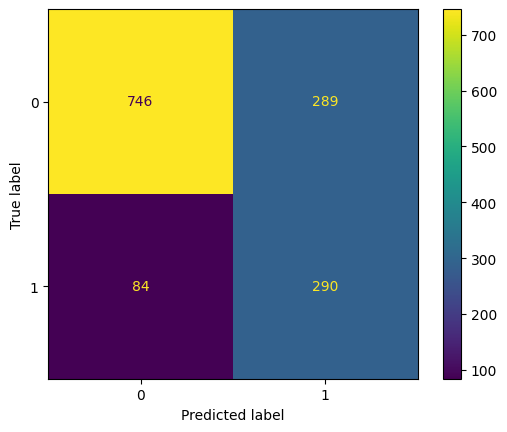

In [27]:
ConfusionMatrixDisplay(confusion_matrix(y_test, logreg.predict(pipeline_oob_xgb.transform(X_test)))).plot();

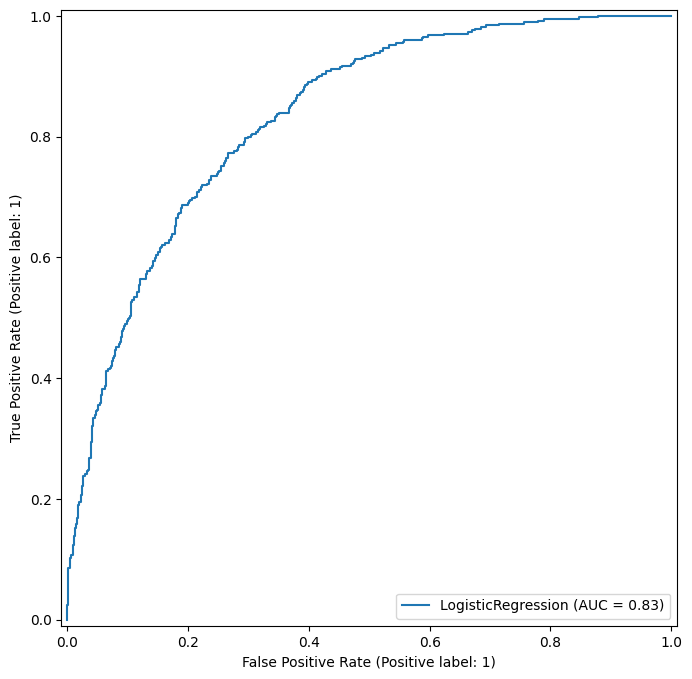

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_estimator(logreg,
                               pipeline_oob_xgb.transform(X_test),
                               y_test,
                               ax=ax,);

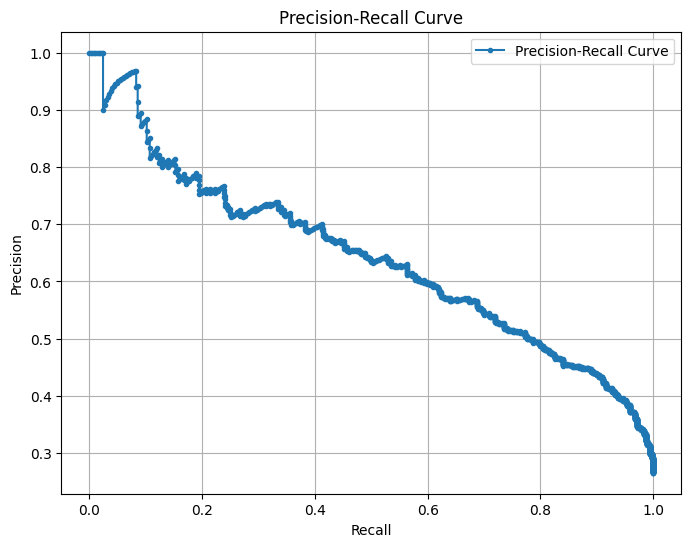

In [29]:
precision, recall, thresholds = precision_recall_curve(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:,1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:,1] > thr) for thr in thresholds]
fbeta_scores = [fbeta_score(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:,1] > thr, beta=1.5) for thr in thresholds]
fbeta_scores1_8 = [fbeta_score(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:,1] > thr, beta=1.8) for thr in thresholds]

# Get threshold with highest F1 score
optimal_threshold_f1 = thresholds[np.argmax(f1_scores)]
optimal_threshold_fbeta = thresholds[np.argmax(fbeta_scores)]
optimal_threshold_fbeta1_8 = thresholds[np.argmax(fbeta_scores1_8)]

print(f'Optimal threshold based on f1: {optimal_threshold_f1}')
print(f'Optimal threshold based on fbeta: {optimal_threshold_fbeta}')
print(f'Optimal threshold based on fbeta1_8: {optimal_threshold_fbeta1_8}')

Optimal threshold based on f1: 0.595959595959596
Optimal threshold based on fbeta: 0.36363636363636365
Optimal threshold based on fbeta1_8: 0.3434343434343435


In [31]:
# Generate predicted probabilities
y_prob = logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:,1]

# Make class predictions based on the optimal threshold
y_pred_adj_threshold_f1 = (y_prob >= optimal_threshold_f1).astype(int)
y_pred_adj_threshold_fbeta = (y_prob >= optimal_threshold_fbeta).astype(int)
y_pred_adj_threshold_fbeta1_8 = (y_prob >= optimal_threshold_fbeta1_8).astype(int)

In [32]:
print('Threshold adjusted based on F1...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_f1)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_f1)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_f1)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_f1)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:, 1])}')

Threshold adjusted based on F1...

Accuracy score: 0.7764371894960965
Precision score: 0.5648351648351648
Recall score: 0.6871657754010695
F1 score: 0.6200241254523522
ROC-AUC score: 0.8327753235681623
Average Precision Score: 0.6424060672444474


In [33]:
print('Threshold adjusted based on FBeta (Recall 1.5x more important than Precision)...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_fbeta)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:, 1])}')

Threshold adjusted based on FBeta (Recall 1.5x more important than Precision)...

Accuracy score: 0.680624556422995
Precision score: 0.44850948509485095
Recall score: 0.8850267379679144
F1 score: 0.5953237410071942
ROC-AUC score: 0.8327753235681623
Average Precision Score: 0.6424060672444474


In [34]:
print('Threshold adjusted based on FBeta (Recall 1.8x more important than Precision)...\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred_adj_threshold_fbeta1_8)}')
print(f'Precision score: {precision_score(y_test, y_pred_adj_threshold_fbeta1_8)}')
print(f'Recall score: {recall_score(y_test, y_pred_adj_threshold_fbeta1_8)}')
print(f'F1 score: {f1_score(y_test, y_pred_adj_threshold_fbeta1_8)}')
print(f'ROC-AUC score: {roc_auc_score(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:, 1])}')
print(f'Average Precision Score: {average_precision_score(y_test, logreg.predict_proba(pipeline_oob_xgb.transform(X_test))[:, 1])}')

Threshold adjusted based on FBeta (Recall 1.8x more important than Precision)...

Accuracy score: 0.6593328601845281
Precision score: 0.43256997455470736
Recall score: 0.9090909090909091
F1 score: 0.5862068965517241
ROC-AUC score: 0.8327753235681623
Average Precision Score: 0.6424060672444474


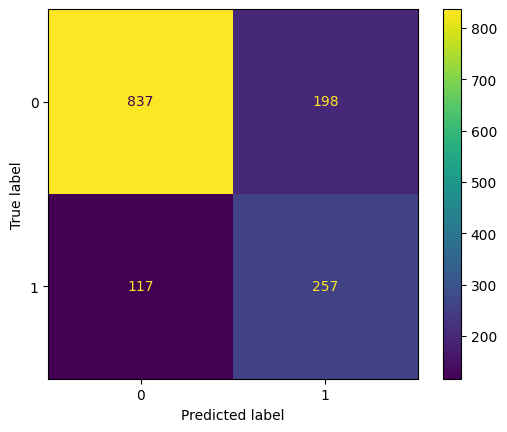

In [35]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_adj_threshold_f1)).plot();

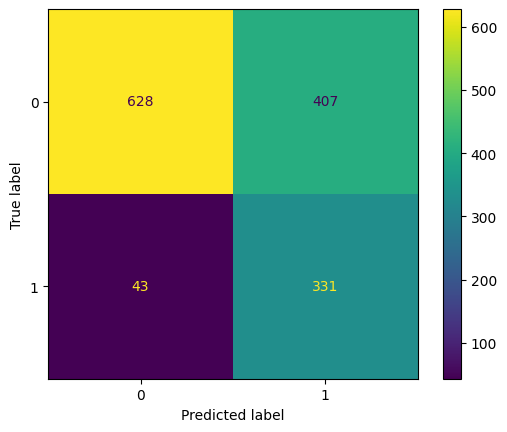

In [36]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_adj_threshold_fbeta)).plot();

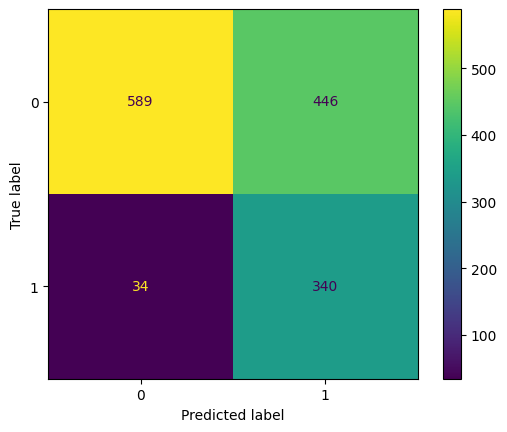

In [37]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_adj_threshold_fbeta1_8)).plot();

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['churn_label']),
                                                    df[['churn_label']].values.ravel(),
                                                    test_size=0.2,
                                                    stratify=df[['churn_label']].values.ravel(),
                                                    random_state=42)

In [39]:
feature_names = pd.DataFrame(col_trans.fit_transform(TweakCustomerChurn().transform(X_train)), 
                             columns=col_trans.get_feature_names_out(input_features=TweakCustomerChurn().transform(X_train).columns)).columns
feature_names

Index(['monthly_purchase_thou_idr_', 'cltv_predicted_thou_idr_',
       'total_spending', 'net_cltv_total_spending', 'location_Jakarta',
       'device_class_Low End', 'device_class_Mid End',
       'games_product_No internet service', 'games_product_Yes',
       'music_product_No internet service', 'music_product_Yes',
       'education_product_No internet service', 'education_product_Yes',
       'video_product_No internet service', 'video_product_Yes',
       'call_center_Yes', 'use_myapp_No internet service', 'use_myapp_Yes',
       'payment_method_Debit', 'payment_method_Digital Wallet',
       'payment_method_Pulsa', 'tenure_segmentation', 'tenure_months',
       'any_digital_product', 'all_digital_product',
       'total_digital_product_used', 'total_product_utilisation'],
      dtype='object')

In [40]:
coefficients = logreg.coef_.flatten()
feature_importance = {}
for coef, feat in zip(coefficients,feature_names):
    feature_importance[feat] = coef

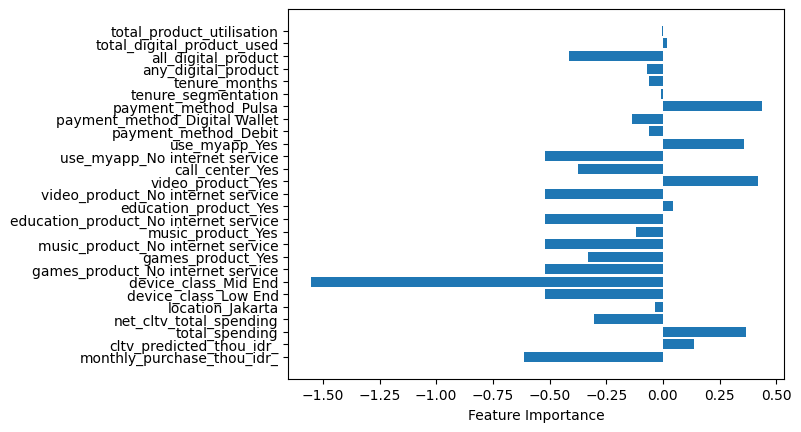

In [41]:
plt.barh(range(len(feature_importance)), list(feature_importance.values()), align='center')
plt.yticks(range(len(feature_importance)), list(feature_importance.keys()))
plt.xlabel('Feature Importance')
plt.show()

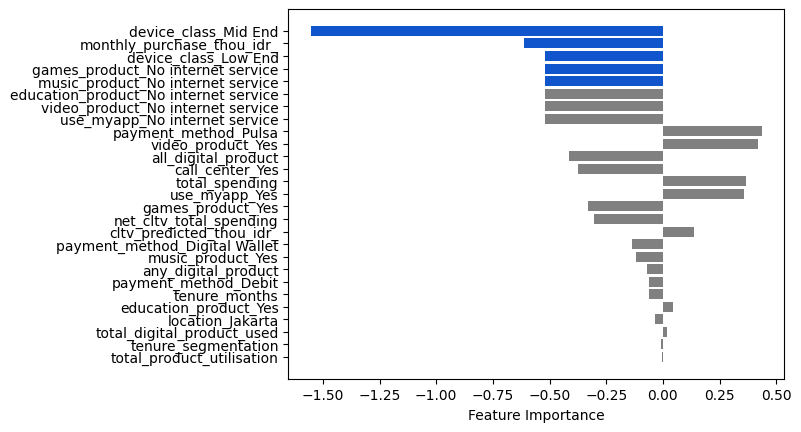

In [42]:
# Assuming 'coefficients' and 'feature_names' are defined earlier in the code.
coefficients = logreg.coef_.flatten()
feature_importance = {feat: coef for coef, feat in zip(coefficients, feature_names)}

# Sort features by the absolute value of their importance
sorted_features = sorted(feature_importance.items(), key=lambda item: abs(item[1]), reverse=True)
sorted_feature_names, sorted_coefficients = zip(*sorted_features)

# Create a list of colors: blue for the top 5, grey for the rest
colors = ['#1155ccff' if i < 5 else 'grey' for i in range(len(sorted_feature_names))]

# Create the plot with the sorted features and colored bars
plt.barh(range(len(sorted_feature_names)), sorted_coefficients, align='center', color=colors)
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the bar with the highest absolute value on top
plt.show()


In [43]:
best_model = logreg
dump(best_model, '../../models/best_model_telco_churn_logreg.joblib')

['../../models/best_model_telco_churn_logreg.joblib']

In [44]:
best_pipeline = pipeline_oob_xgb
dump(best_pipeline, '../../models/best_pipeline_telco_churn_logreg.joblib')

['../../models/best_pipeline_telco_churn_logreg.joblib']